<a href="https://colab.research.google.com/github/danielma4/motion_detection/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy import ndimage

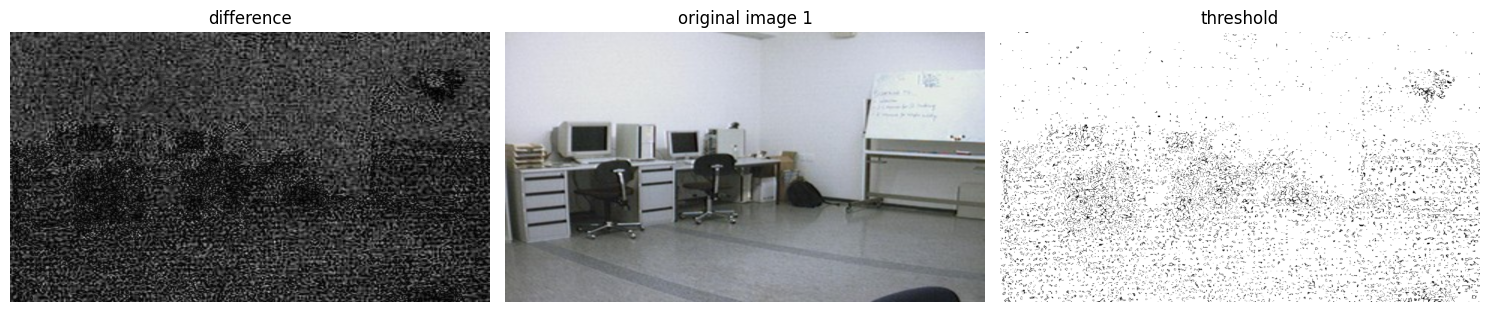

In [ ]:
def load_frames(video_dir, num_frames=None):
    frame_paths = sorted(glob(os.path.join(video_dir, '*.jpg')))
    if num_frames:
        frame_paths = frame_paths[:num_frames]
    frames = []
    for path in frame_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            frames.append(img.astype(np.float32))
    return np.array(frames)

def create_1d_gaussian(sigma, truncate=3.0):
    radius = int(truncate * sigma + 0.5)
    x = np.arange(-radius, radius + 1)
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    kernel = kernel / kernel.sum()
    return kernel

def derivative_of_gaussian_1d(sigma, truncate=3.0):
    radius = int(truncate * sigma + 0.5)
    x = np.arange(-radius, radius + 1)
    kernel = -x / (sigma ** 2) * np.exp(-0.5 * (x / sigma) ** 2)
    kernel = kernel / np.abs(kernel).sum()
    return kernel

def create_2d_gaussian(sigma, truncate=3.0):
    radius = int(truncate * sigma + 0.5)
    size = 2 * radius + 1
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x = i - radius
            y = j - radius
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

def apply_temporal_filter(frames, kernel):
    filtered = np.zeros_like(frames)
    n_frames = len(frames)
    k_len = len(kernel)
    k_half = k_len // 2
    
    for t in range(n_frames):
        result = np.zeros_like(frames[0])
        for i, k_val in enumerate(kernel):
            t_idx = t + i - k_half
            if 0 <= t_idx < n_frames:
                result += k_val * frames[t_idx]
        filtered[t] = result
    return filtered

def apply_spatial_filter(frame, kernel):
    if len(kernel.shape) == 1:
        filtered = ndimage.convolve1d(frame, kernel, axis=0)
        filtered = ndimage.convolve1d(filtered, kernel, axis=1)
    else:
        filtered = ndimage.convolve(frame, kernel)
    return filtered

def threshold_motion(derivative, threshold):
    return (np.abs(derivative) > threshold).astype(np.uint8) * 255

def overlay_mask_on_frame(frame, mask, color=[0, 255, 0]):
    if len(frame.shape) == 2:
        frame_color = cv2.cvtColor((frame).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    else:
        frame_color = frame.copy()
    
    mask_binary = (mask > 0).astype(np.uint8)
    overlay = frame_color.copy()
    overlay[mask_binary == 1] = color
    result = cv2.addWeighted(frame_color, 0.7, overlay, 0.3, 0)
    return result

def estimate_noise_std(temporal_derivatives, percentile=50):
    background_pixels = temporal_derivatives[np.abs(temporal_derivatives) < np.percentile(np.abs(temporal_derivatives), percentile)]
    return np.std(background_pixels)

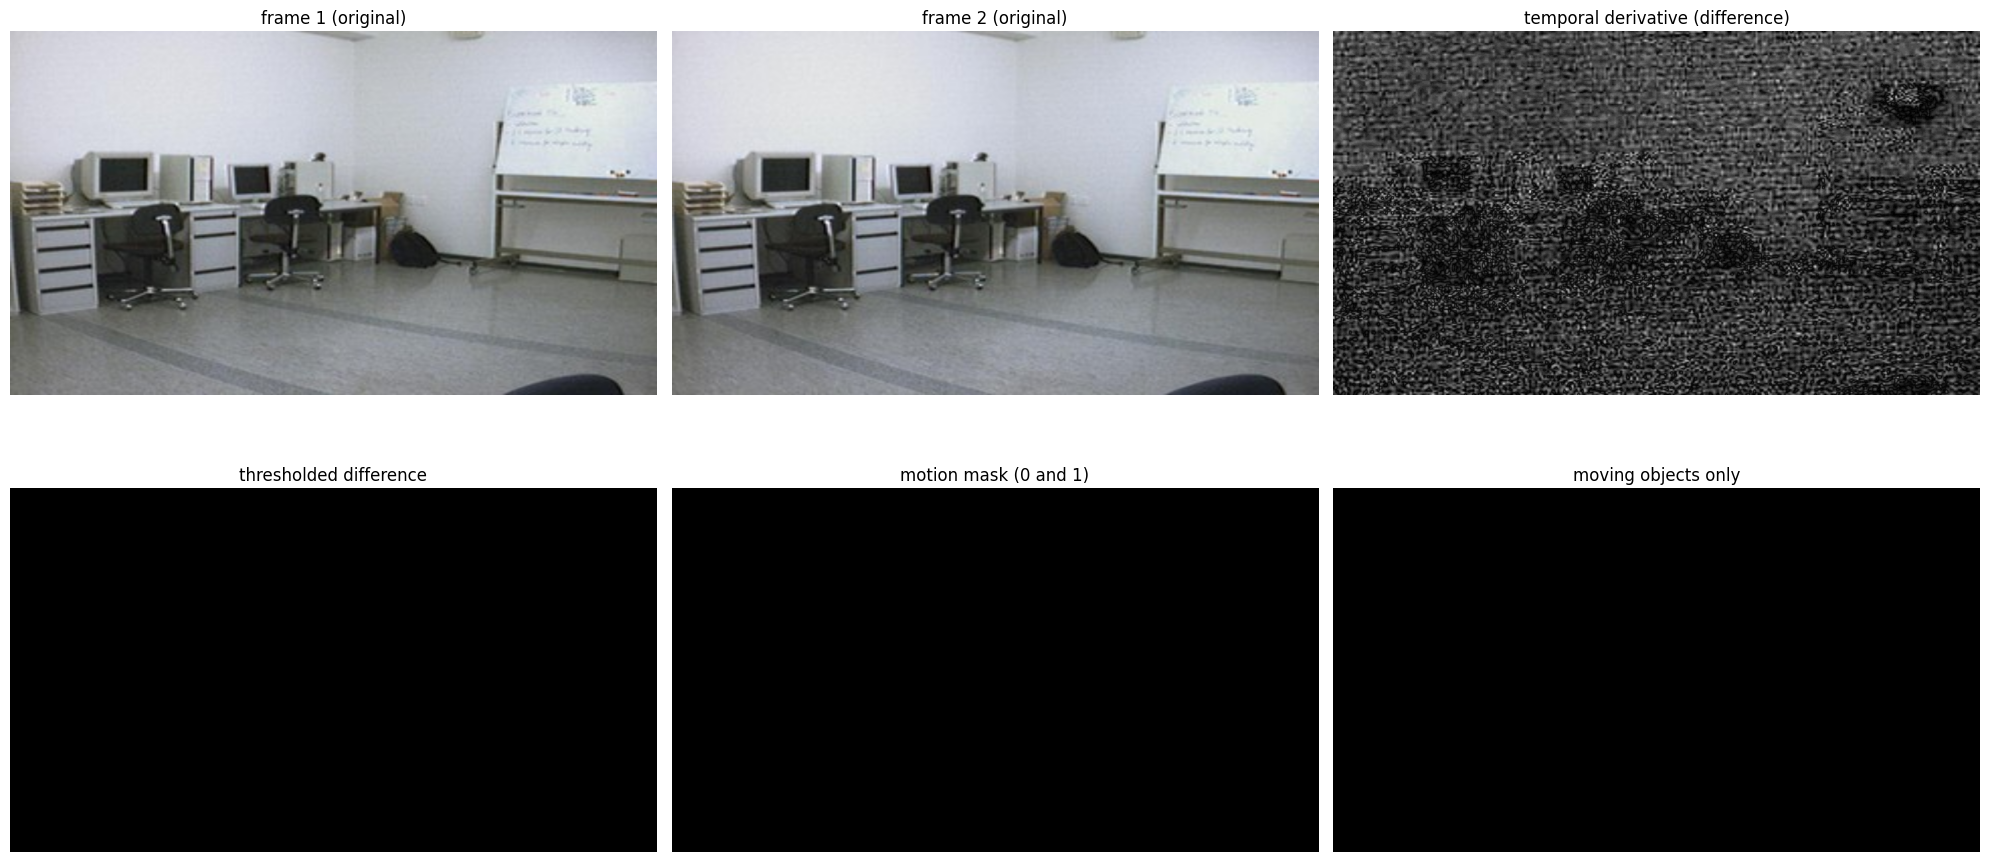

In [ ]:
video_dir = 'videos/RedChair/RedChair'
frames = load_frames(video_dir, num_frames=50)
print(f'loaded {len(frames)} frames of shape {frames[0].shape}')

In [ ]:
simple_derivative = np.array([-0.5, 0, 0.5])
t_sigmas = [1.0, 2.0, 3.0]

temporal_derivs = {}
temporal_derivs['simple'] = apply_temporal_filter(frames, simple_derivative)

for t_sigma in t_sigmas:
    dog_kernel = derivative_of_gaussian_1d(t_sigma)
    temporal_derivs[f'dog_sigma_{t_sigma}'] = apply_temporal_filter(frames, dog_kernel)

frame_idx = 25
threshold_val = 30

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].imshow(frames[frame_idx], cmap='gray')
axes[0, 0].set_title('original frame')
axes[0, 0].axis('off')

axes[0, 1].imshow(np.abs(temporal_derivs['simple'][frame_idx]), cmap='hot')
axes[0, 1].set_title('simple derivative')
axes[0, 1].axis('off')

axes[1, 1].imshow(threshold_motion(temporal_derivs['simple'][frame_idx], threshold_val), cmap='gray')
axes[1, 1].set_title('simple (thresholded)')
axes[1, 1].axis('off')

for idx, t_sigma in enumerate(t_sigmas):
    key = f'dog_sigma_{t_sigma}'
    col = idx + 2
    
    axes[0, col].imshow(np.abs(temporal_derivs[key][frame_idx]), cmap='hot')
    axes[0, col].set_title(f'dog σ={t_sigma}')
    axes[0, col].axis('off')
    
    axes[1, col].imshow(threshold_motion(temporal_derivs[key][frame_idx], threshold_val), cmap='gray')
    axes[1, col].set_title(f'dog σ={t_sigma} (thresh)')
    axes[1, col].axis('off')

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()

print('comparison of temporal filters:')
print('- simple derivative: sharp, noisy, detects all intensity changes')
print('- derivative of gaussian: smoother, reduces noise with larger sigma')
print('- larger sigma values suppress high-frequency noise but may blur motion boundaries')

In [ ]:
simple_derivative = np.array([-0.5, 0, 0.5])

temporal_deriv = apply_temporal_filter(frames, simple_derivative)

threshold_val = 30
motion_mask = threshold_motion(temporal_deriv, threshold_val)

frame_idx = 25
original_frame = frames[frame_idx]
derivative_frame = temporal_deriv[frame_idx]
mask_frame = motion_mask[frame_idx]
overlay_frame = overlay_mask_on_frame(original_frame, mask_frame)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(original_frame, cmap='gray')
axes[0, 0].set_title('original frame')
axes[0, 0].axis('off')

axes[0, 1].imshow(np.abs(derivative_frame), cmap='hot')
axes[0, 1].set_title('temporal derivative (absolute)')
axes[0, 1].axis('off')

axes[1, 0].imshow(mask_frame, cmap='gray')
axes[1, 0].set_title(f'binary motion mask (threshold={threshold_val})')
axes[1, 0].axis('off')

axes[1, 1].imshow(overlay_frame)
axes[1, 1].set_title('motion overlay on original')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'none' is not defined

In [ ]:
simple_derivative = np.array([-0.5, 0, 0.5])
box_3x3 = np.ones((3, 3)) / 9
box_5x5 = np.ones((5, 5)) / 25
s_sigmas = [0.5, 1.0, 2.0]

results = {}

results['no_spatial'] = apply_temporal_filter(frames, simple_derivative)

frames_box3 = np.array([apply_spatial_filter(f, box_3x3) for f in frames])
results['box_3x3'] = apply_temporal_filter(frames_box3, simple_derivative)

frames_box5 = np.array([apply_spatial_filter(f, box_5x5) for f in frames])
results['box_5x5'] = apply_temporal_filter(frames_box5, simple_derivative)

for s_sigma in s_sigmas:
    gaussian_2d = create_2d_gaussian(s_sigma)
    frames_gauss = np.array([apply_spatial_filter(f, gaussian_2d) for f in frames])
    results[f'gauss_sigma_{s_sigma}'] = apply_temporal_filter(frames_gauss, simple_derivative)

frame_idx = 25
threshold_val = 30

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

axes[0, 0].imshow(frames[frame_idx], cmap='gray')
axes[0, 0].set_title('original frame')
axes[0, 0].axis('off')

axes[0, 1].imshow(np.abs(results['no_spatial'][frame_idx]), cmap='hot')
axes[0, 1].set_title('no spatial smoothing')
axes[0, 1].axis('off')

axes[0, 2].imshow(threshold_motion(results['no_spatial'][frame_idx], threshold_val), cmap='gray')
axes[0, 2].set_title('no spatial (thresh)')
axes[0, 2].axis('off')

axes[1, 0].imshow(np.abs(results['box_3x3'][frame_idx]), cmap='hot')
axes[1, 0].set_title('3x3 box filter')
axes[1, 0].axis('off')

axes[1, 1].imshow(threshold_motion(results['box_3x3'][frame_idx], threshold_val), cmap='gray')
axes[1, 1].set_title('3x3 box (thresh)')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.abs(results['box_5x5'][frame_idx]), cmap='hot')
axes[1, 2].set_title('5x5 box filter')
axes[1, 2].axis('off')

for idx, s_sigma in enumerate(s_sigmas):
    key = f'gauss_sigma_{s_sigma}'
    row = 2
    col = idx
    
    axes[row, col].imshow(np.abs(results[key][frame_idx]), cmap='hot')
    axes[row, col].set_title(f'gaussian σ={s_sigma}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
for idx, s_sigma in enumerate(s_sigmas):
    key = f'gauss_sigma_{s_sigma}'
    col = idx
    
    axes2[0, col].imshow(np.abs(results[key][frame_idx]), cmap='hot')
    axes2[0, col].set_title(f'gaussian σ={s_sigma}')
    axes2[0, col].axis('off')
    
    axes2[1, col].imshow(threshold_motion(results[key][frame_idx], threshold_val), cmap='gray')
    axes2[1, col].set_title(f'gaussian σ={s_sigma} (thresh)')
    axes2[1, col].axis('off')

plt.tight_layout()
plt.show()

print('spatial smoothing comparison:')
print('- no spatial smoothing: noisy, many false positives from sensor noise')
print('- 3x3 box filter: reduces noise slightly, preserves edges moderately')
print('- 5x5 box filter: more noise reduction, some edge blurring')
print('- gaussian filters: best noise reduction with edge preservation')
print('- optimal: gaussian with σ=1.0 balances noise reduction and motion detail')

In [ ]:
s_sigma = 1.0
gaussian_2d = create_2d_gaussian(s_sigma)
frames_smoothed = np.array([apply_spatial_filter(f, gaussian_2d) for f in frames])

simple_derivative = np.array([-0.5, 0, 0.5])
temporal_deriv = apply_temporal_filter(frames_smoothed, simple_derivative)

noise_std = estimate_noise_std(temporal_deriv.flatten())
print(f'estimated background noise std: {noise_std:.2f}')

threshold_multipliers = [1.0, 2.0, 3.0, 4.0]
frame_idx = 25

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].imshow(frames[frame_idx], cmap='gray')
axes[0, 0].set_title('original frame')
axes[0, 0].axis('off')

axes[1, 0].imshow(np.abs(temporal_deriv[frame_idx]), cmap='hot')
axes[1, 0].set_title('temporal derivative')
axes[1, 0].axis('off')

for idx, mult in enumerate(threshold_multipliers):
    threshold_val = mult * noise_std
    motion_mask = threshold_motion(temporal_deriv[frame_idx], threshold_val)
    
    col = idx + 1
    if col < 4:
        axes[0, col].imshow(motion_mask, cmap='gray')
        axes[0, col].set_title(f'threshold = {mult}σ ({threshold_val:.1f})')
        axes[0, col].axis('off')
        
        overlay = overlay_mask_on_frame(frames[frame_idx], motion_mask)
        axes[1, col].imshow(overlay)
        axes[1, col].set_title(f'{mult}σ overlay')
        axes[1, col].axis('off')

plt.tight_layout()
plt.show()

print('\nthreshold strategy comparison:')
print(f'- 1σ: very sensitive, many false positives from noise')
print(f'- 2σ: balanced, captures most motion with some noise')
print(f'- 3σ: conservative, good motion detection with minimal false positives')
print(f'- 4σ: very conservative, may miss subtle motion')
print(f'\nrecommended: 3σ threshold for robust motion detection')